<a href="https://colab.research.google.com/github/oneoftwo/KAIST_CH453_AI_chemistry/blob/main/assignments/assignment_3/assignment_3_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**You only need to implement the #TODO parts**

# **Get data**

In [ ]:
def make_random_rotation_matrix():
    # Random angle
    theta = np.random.uniform(0, 2 * np.pi)

    # Random axis
    axis = np.random.randn(3)
    axis = axis / np.linalg.norm(axis)

    # Cosine and sine of the rotation angle
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    # One minus the cosine
    one_minus_cos = 1 - cos_theta

    # Outer product of the axis vector with itself
    axis_outer = np.outer(axis, axis)
    # Cross-product matrix of the axis vector
    axis_skew = np.array([[0, -axis[2], axis[1]],
                          [axis[2], 0, -axis[0]],
                          [-axis[1], axis[0], 0]])

    # Rotation matrix using the Rodriguez formula
    rotation_matrix = (cos_theta * np.eye(3)) + \
                      (one_minus_cos * axis_outer) + \
                      (sin_theta * axis_skew)

    return rotation_matrix



In [ ]:
# DO NOT CHANGE!
!rm -r CH*
!rm -r assignment*
!rm -r practice*
!git clone https://github.com/oneoftwo/KAIST_CH453_AI_chemistry/
!mv ./KAIST_CH453_AI_chemistry/assignments/assignment_3/ ./
!rm -r KAIST_CH453*
!pip install rdkit
import rdkit
print(rdkit.__version__)
!ls

Cloning into 'CH453_AI_chemistry'...
remote: Enumerating objects: 2061, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 2061 (delta 60), reused 143 (delta 56), pack-reused 1912
Receiving objects: 100% (2061/2061), 5.77 MiB | 7.73 MiB/s, done.
Resolving deltas: 100% (62/62), done.
CH453_AI_chemistry  sample_data
assignment_1  assignment_3	  data	      practice_1  README.md
assignment_2  CH453_AI_chemistry  practice_0  practice_3  sample_data
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 51.3 MB/s eta 0:00:00
2023.09.1


# **Dataset**

In [ ]:
import torch
from torch.utils.data import Dataset
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
import numpy as np


class GraphConformerDataset(Dataset):

    def __init__(self, mol_list, gap_list):
        super().__init__()
        self.mol_list = mol_list
        self.gap_list = gap_list

    def __len__(self):
        return len(self.mol_list)

    def __getitem__(self, idx):
        '''
        return a dict of {"h": input, "target": target, "adj": adj, "num_atom": num_atom}
        where,
        input: a [n_atom] sized tensor, atomic numbers for CCON [6 6 8 7]
        target: a logp value
        adj: adjacency matrix [n_atom * n_atom]
        nim_atom: n_atom
        '''
        sample = {}
        mol = self.mol_list[idx]

        sample["target"] = self.mol_to_logp(mol)

        sample["h"] = self.mol_to_atom_number_list(mol) # node feature matrix
        sample["adj"] = torch.Tensor(self.mol_to_adj(mol)).long()
        sample["e"] = self.mol_to_e(mol)
        sample['x'] = torch.Tensor(self.mol_to_x(mol))
        sample["gap"] = self.gap_list[idx]
        sample["logp"] = self.mol_to_logp(mol)
        return sample

    def mol_to_atom_number_list(self, mol):
        atomic_numbers = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
        return atomic_numbers

    def mol_to_adj(self, mol):
        num_atoms = mol.GetNumAtoms()
        adj_matrix = np.zeros((num_atoms, num_atoms), dtype=int)
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            adj_matrix[start, end] = 1
            adj_matrix[end, start] = 1
        return adj_matrix

    def mol_to_logp(self, mol):
        return Descriptors.MolLogP(mol)

    def mol_to_e(self, mol):
        num_atoms = mol.GetNumAtoms()
        # Initialize the edge feature matrix with zeros
        e_features = np.zeros((num_atoms, num_atoms), dtype=int)

        # Mapping from bond type to one-hot index
        bond_type_to_index = {
            Chem.rdchem.BondType.SINGLE: 0,
            Chem.rdchem.BondType.DOUBLE: 1,
            Chem.rdchem.BondType.TRIPLE: 2,
            Chem.rdchem.BondType.AROMATIC: 3
        }

        # Populate the edge feature matrix
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            bond_type = bond.GetBondType()

            # Get the one-hot index for the current bond type
            bond_index = bond_type_to_index[bond_type]

            # Set the corresponding position to 1 for one-hot encoding
            e_features[start, end] = bond_index
            e_features[end, start] = bond_index # Undirected graph - set for both directions

        return torch.tensor(e_features, dtype=torch.long)

    def mol_to_x(self, mol):
        # a function that generates [N, 3] position matrix from rdkit.Mol
        conf = mol.GetConformer()
        num_atoms = mol.GetNumAtoms()
        coords = np.zeros((num_atoms, 3), dtype=np.float32)
        for i in range(num_atoms):
            position = conf.GetAtomPosition(i)
            coords[i] = [position.x, position.y, position.z]
        return coords


In [ ]:
def graph_collate_fn(batch):
    # Find the maximum number of atoms in this batch
    max_atoms = max(sample['adj'].shape[0] for sample in batch)

    # Initialize padded tensors
    h_padded = torch.zeros(len(batch), max_atoms, dtype=torch.long)
    adj_padded = torch.zeros(len(batch), max_atoms, max_atoms, dtype=torch.long)
    e_padded = torch.zeros(len(batch), max_atoms, max_atoms)
    targets = torch.zeros(len(batch), dtype=torch.float32)
    logps = torch.zeros(len(batch), dtype=torch.float32)
    num_atoms = torch.zeros(len(batch), dtype=torch.long)
    x_padded = torch.zeros(len(batch), max_atoms, 3, dtype=torch.long)


    # Fill in the padded tensors
    for i, sample in enumerate(batch):
        num_atoms_i = sample['adj'].shape[0]
        h_padded[i, :num_atoms_i] = torch.tensor(sample['h'])
        adj_padded[i, :num_atoms_i, :num_atoms_i] = sample['adj']
        e_padded[i, : num_atoms_i,: num_atoms_i] = sample["e"]
        targets[i] = sample['gap']
        logps[i] = sample["logp"]
        num_atoms[i] = num_atoms_i
        x_padded[i, :num_atoms_i, :] = sample["x"]


    return {
        'h': h_padded,
        'adj': adj_padded,
        "e": e_padded,
        "x": x_padded,
        'gap': targets,
        "logp": logps,
        'num_atom': num_atoms
    }


# **Model**

## **MPNN**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class MPNNRegressor(nn.Module):

    def __init__(
            self,
            hid_dim,
            n_layer
            ):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layer = n_layer

        self.embd_h = nn.Embedding(130, hid_dim) # 118 atom types -> hid_dim,
        self.embd_e = nn.Embedding(4, hid_dim) # 4 edge types -> hid_dim

        self.mpnn_layers = nn.ModuleList([MPNNLayer(hid_dim) for _ in range(n_layer)])

        self.readout_fc = nn.Sequential(
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, 1)
        )

    def forward(self, h, adj, e):
        '''
        N: number of max nodes, adj: adjacency matrix
        1. embed h to hidden dim ([bs, N] > [bs, N, hid_dim])
        2. go through gcn layres, update node features (A @ H @ W) [bs, N, hid_dim]
        3. apply sum read out
        4. readout
        '''
        ##########Implement Here!##########

        # 1. embd
        h = self.embd_h(h) # [N, 256]
        e = self.embd_e(e) # [N, N, 256]

        # 2. layers
        for layer in self.mpnn_layers:
            h = layer(h, adj, e)
            h = F.relu(h)

        # 3. Apply sum readout
        h_sum = h.sum(dim=1) # [bs, N, hid_dim] -> [bs, hid_dim]

        # 4. Readout
        output = self.readout_fc(h_sum)
        return output.squeeze(1)



class MPNNLayer(nn.Module):
    def __init__(self, hid_dim):
        super(MPNNLayer, self).__init__()
        self.make_message = nn.Linear(hid_dim * 3, hid_dim, bias=True)
        self.node_update = nn.Linear(hid_dim * 2, hid_dim, bias=True)

    def forward(self, h, adj, e):
        # h is the node feature matrix of shape [bs, N, hid_dim]
        # adj is the adjacency matrix of shape [bs, N, N]
        # e is the edge feature tensor of shape [bs, N, N, hid_dim]

        # make h repeated
        N = h.size(1)
        h_1 = h.unsqueeze(2).repeat(1, 1, N, 1) # [bs, N, 1, hid_dim]
        h_2 = h.unsqueeze(1).repeat(1, N, 1, 1) # [bs, 1, N, hid_dim]

        m = torch.cat([h_1, h_2, e], dim=3) # [bs, N, N, hid_dim * 3]
        m = self.make_message(m) # [bs, N, N, hid_dim]

        # multiply adj to get only "real edges"
        m = m * adj.unsqueeze(3)

        # sum up the message over node
        m = m.sum(1) # [bs, N, hid_dim]

        # Concatenate the summed message vectors with the node features
        h_cat = torch.cat((h, m), dim=2)

        # Update node features with the concatenated features
        h_updated = self.node_update(h_cat)

        return h_updated


## **EGNN**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

class EGNNRegressor(nn.Module):

    def __init__(
            self,
            hid_dim,
            n_layer
            ):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layer = n_layer

        self.embd_h = nn.Embedding(130, hid_dim) # 118 atom types -> hid_dim,
        self.embd_e = nn.Embedding(4, hid_dim) # 4 edge types -> hid_dim

        self.egnn_layers = nn.ModuleList([EGNNLayer(hid_dim) for _ in range(n_layer)])

        self.readout_fc = nn.Sequential(
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, 1)
        )

    def forward(self, h, x, adj, e):
        '''
        N: number of max nodes, adj: adjacency matrix
        1. embed h to hidden dim ([bs, N] > [bs, N, hid_dim])
        2. go through gcn layres, update node features (A @ H @ W) [bs, N, hid_dim]
        3. apply sum read out
        4. readout
        '''

        # 1. embd
        h = self.embd_h(h) # [N, hid_dim]
        e = self.embd_e(e) # [N, N, hid_dim]

        # 2. layers
        for layer in self.egnn_layers:
            h, x = layer(h, x, adj, e)
            h = F.relu(h)

        # 3. Apply sum readout
        # TODO

        # 4. Readout
        # TODO

        return output.squeeze(1)



class EGNNLayer(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.make_message = nn.Linear(hid_dim * 3 + 1, hid_dim, bias=True)
        self.x_alpha = nn.Linear(hid_dim, 1)
        self.node_update = nn.Linear(hid_dim * 2, hid_dim, bias=True)

    def forward(self, h, x, adj, e):
        # TODO
        pass
        return h_updated, x_updated


# **Process**

## **Processors for MPNN and EGNN**

In [ ]:
import torch
from torch.nn import functional as F
from tqdm.notebook import tqdm


def single_epoch_mpnn(model, data_loader, optimizer=None):
    # trains model for single epoch with given data_loader
    total_loss = 0.0

    for batch_sample in tqdm(data_loader):
        h = batch_sample["h"]
        adj = batch_sample["adj"]
        e = batch_sample["e"]
        target = batch_sample["gap"]

        pred_target = model(h.cuda().long(), adj.cuda().float(), e.cuda().long())
        loss = F.mse_loss(pred_target.cuda(), target.cuda(), reduction="mean")

        if optimizer != None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

    result_dict = {}
    result_dict["loss"] = total_loss / len(data_loader)

    return result_dict


def single_epoch_egnn(model, data_loader, optimizer=None):
    total_loss = 0.0

    for batch_sample in tqdm(data_loader):
        h = batch_sample["h"]
        adj = batch_sample["adj"]
        e = batch_sample["e"]
        target = batch_sample["gap"]
        x = batch_sample['x']

        pred_target = model(h.cuda().long(), x.cuda(), adj.cuda().float(), e.cuda().long())
        loss = F.mse_loss(pred_target.cuda(), target.cuda(), reduction="mean")

        if optimizer != None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

    result_dict = {}
    result_dict["loss"] = total_loss / len(data_loader)

    return result_dict


# **Run**

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
import pickle


# read processed data file
mols_fn = "./assignment_3/data.pkl"
with open(mols_fn, "rb") as f:
    mols = pickle.load(f)
gaps_fn = "./assignment_3/gap.pkl"
with open(gaps_fn, "rb") as f:
    gaps = pickle.load(f)

data_set = GraphConformerDataset(mols, gaps)

# split dataset into train / valid (conventionaly, 8:2)
train_set, valid_set = random_split(data_set, [0.8, 0.2])
print(f"length of train, valid, and test set: {len(train_set), len(valid_set)}")

# define data loader which batches dataset
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2,
                          collate_fn=graph_collate_fn)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False, num_workers=2,
                          collate_fn=graph_collate_fn)

# define model
model = EGNNRegressor(hid_dim=256, n_layer=5)
model.cuda()
print(model)

# set optimizer (Adam is the most frequently used optimizer)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-8)

# train
train_loss_history, valid_loss_history = [], []
for epoch_idx in range(1, 31):
    model.train()
    tr = single_epoch_egnn(model, train_loader, optimizer)
    train_loss_history.append(tr["loss"])

    with torch.no_grad():
        model.eval()
        vr = single_epoch_egnn(model, valid_loader)
        valid_loss_history.append(vr["loss"])

    torch.save(model.state_dict(), f"./model_{epoch_idx}.pt")

    print(epoch_idx)
    print(tr)
    print(vr)
    print()


length of train, valid, and test set: (784, 98, 98)
MPNNRegressor(
  (embd_h): Embedding(130, 128)
  (embd_e): Embedding(4, 128)
  (mpnn_layers): ModuleList(
    (0-4): 5 x MPNNLayer(
      (make_message): Linear(in_features=384, out_features=128, bias=True)
      (node_update): Linear(in_features=256, out_features=128, bias=True)
    )
  )
  (readout_fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

1
{'loss': 0.008551553254947067}
{'loss': 0.004625497502274811}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

2
{'loss': 0.004425766784697771}
{'loss': 0.002715049253311008}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

3
{'loss': 0.0034144159266725183}
{'loss': 0.002736170688876882}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

4
{'loss': 0.0029068436194211243}
{'loss': 0.0027180950855836272}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

5
{'loss': 0.002512968508526683}
{'loss': 0.002541749970987439}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

6
{'loss': 0.0022484950255602597}
{'loss': 0.0022802703315392137}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

7
{'loss': 0.0020492902235127986}
{'loss': 0.002057788398815319}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

8
{'loss': 0.0019369730446487665}
{'loss': 0.002045352099230513}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

9
{'loss': 0.0018533164239488541}
{'loss': 0.0017836073966464028}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

10
{'loss': 0.0016798826144076883}
{'loss': 0.001654027175391093}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

11
{'loss': 0.0015669514634646475}
{'loss': 0.0015169368562055752}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

12
{'loss': 0.0015129726589657366}
{'loss': 0.0014438624639296904}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

13
{'loss': 0.001400340562686324}
{'loss': 0.0012668805429711938}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

14
{'loss': 0.0012997621693648397}
{'loss': 0.0011604015162447467}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

15
{'loss': 0.001258308095857501}
{'loss': 0.0010744966275524348}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

16
{'loss': 0.0011951088043861092}
{'loss': 0.001018439041217789}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

17
{'loss': 0.0011029139533638955}
{'loss': 0.0008627166389487684}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

18
{'loss': 0.0010813363734632731}
{'loss': 0.0008636196580482647}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

19
{'loss': 0.0010571405629161744}
{'loss': 0.0009092227264773101}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

20
{'loss': 0.0010020079917740076}
{'loss': 0.0007358028706221376}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

21
{'loss': 0.000999195120530203}
{'loss': 0.0009299907546846953}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

22
{'loss': 0.0009618461213540285}
{'loss': 0.0006416842770704534}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

23
{'loss': 0.0008892981149256229}
{'loss': 0.0006302206784312148}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

24
{'loss': 0.000831479886546731}
{'loss': 0.0006160780103527941}



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

25
{'loss': 0.0008115735021419823}
{'loss': 0.0005617859496851452}



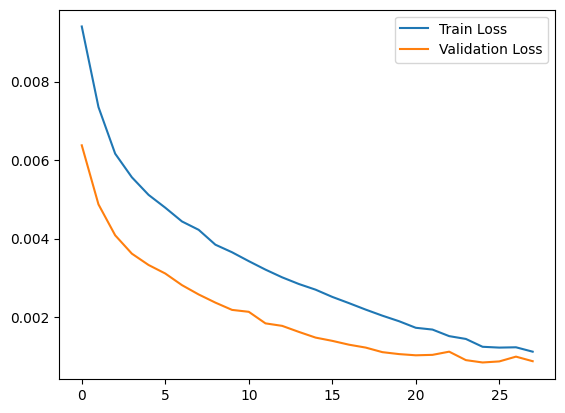

In [ ]:
## plot the results
from matplotlib import pyplot as plt


plt.plot(train_loss_history[2:], label='Train Loss')
plt.plot(valid_loss_history[2:], label='Validation Loss')
plt.legend(loc='upper right')
plt.show()


  0%|          | 0/4 [00:00<?, ?it/s]

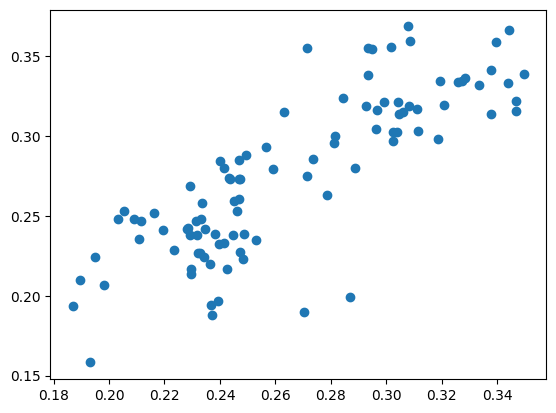

In [ ]:
# make prediction

all_pred_logp = []
all_true_logp = []
for batch_sample in tqdm(valid_loader):
    h = batch_sample["h"]
    adj = batch_sample["adj"]
    e = batch_sample['e']
    logp = batch_sample["gap"]
    x = batch_sample["x"]

    pred_logp = model(h.cuda().long(), x.cuda(), adj.cuda().float(), e.cuda().long())
    all_pred_logp += pred_logp.cpu().tolist()
    all_true_logp += logp.tolist()


plt.scatter(all_pred_logp, all_true_logp)
# plt.xlim([-5, 10])
# plt.ylim([-5, 10])
plt.show()